In [1]:
import os
import torch
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from helpers import get_files_in_dir
from torchvision.io import read_image

from embed import PatchEmbedding


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
from figures_dataset import FiguresData
train_dataset = FiguresData(128,2000, augment=True)
print("Training ponits: ",len(train_dataset))

valid_dataset = FiguresData(128,300, augment=False)
print("Validation ponits: ",len(valid_dataset))


Training ponits:  2000
Validation ponits:  300


tensor(0, device='cuda:0')


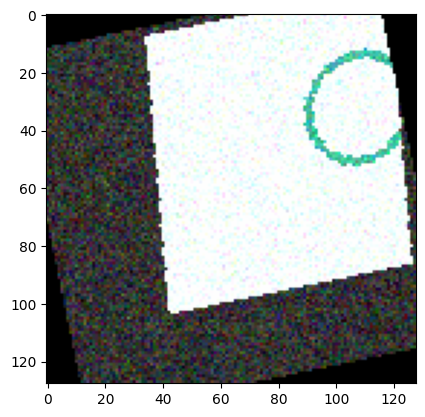

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


tensor(0, device='cuda:0')


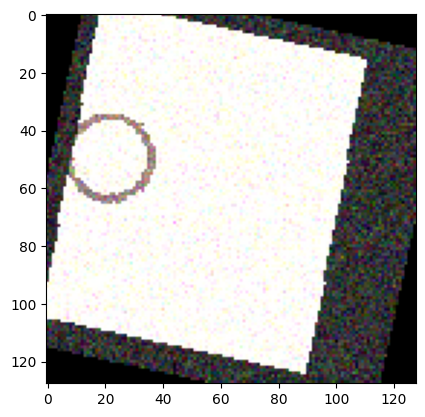

tensor(3, device='cuda:0')


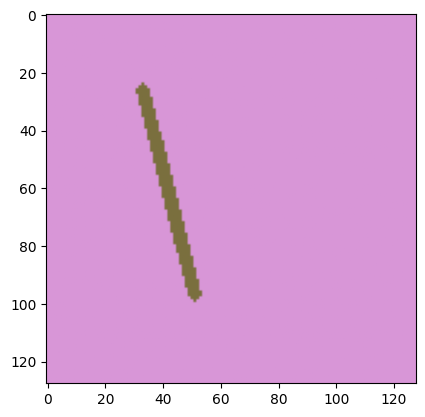

tensor(3, device='cuda:0')


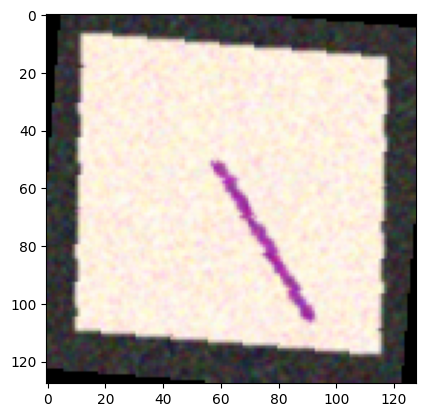

tensor(1, device='cuda:0')


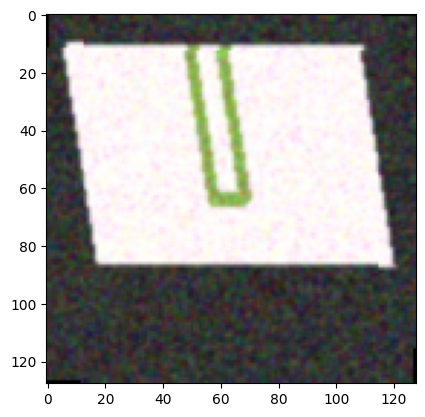

In [4]:
#terate training_set and visualize 
for i in range(5):
    # random int 
    j = torch.randint(0, len(train_dataset),(1,)).item() 
    print(train_dataset[j][1])
    plt.imshow(train_dataset[j][0].permute(1, 2, 0).to('cpu'))
    plt.show()

In [5]:
# TRAINING IMPORTS
from torch import nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torcheval.metrics.functional import multiclass_accuracy
from torch.nn import CrossEntropyLoss
from nip import Nip
from simple import SimpleModel, SimpleTrainer

Using cuda device
Using cuda device
torch.Size([32, 5])


ImportError: cannot import name 'SimpleTrainer' from 'simple' (c:\NNMultiClassClassifier\simple.py)

In [8]:
# MODEL
model_config = {
    "img_size": 128,
    "classes": 5,
    "id_" : 1,
    "patch_size" : 32,
    "embed_dim" : 100,
}

from_checkpoint = False

model = SimpleModel(**model_config)

if from_checkpoint:
    p = 'nip_models/model_{}.pt'.format(model.id_)
    model.load_state_dict(torch.load(p, weights_only=True))

model = model.to(device)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)


for i, batch in zip(range(len(train_loader)),train_loader):
    images, labels = batch
    with torch.no_grad():   
        ret = model(images.to(device))
        print(ret.shape)
    break


# for name,param in model.named_parameters():
#     print(name, param.size())
#     param.requires_grad = False

model.print_sizes()

ps = 0
for name, param in model.named_parameters():
    #print(f"Layer: {name} | Size: {param.size()} \n")
    if "nope" in name:# or "head" in name:
        param.requires_grad = True
        print("Trainable: ",name)
    else:
        param.requires_grad = False
        print("Frozen: ",name)
    if param.requires_grad: 
        ps += param.numel()

print("Params to train: ",ps)


torch.Size([32, 5])
Patch Embed:  torch.Size([100, 3072])  Grad:  True
Lin1:  torch.Size([100, 100])  Grad:  True
Lin2:  torch.Size([60, 100])  Grad:  True
Lin3:  torch.Size([10, 60])  Grad:  True
Combine:  torch.Size([85, 170])  Grad:  True
Head:  torch.Size([5, 85])  Grad:  True
Frozen:  batch_norm.weight
Frozen:  batch_norm.bias
Frozen:  patch_embed.pos_embed
Frozen:  patch_embed.cls_token
Frozen:  patch_embed.patch_embed.weight
Frozen:  patch_embed.patch_embed.bias
Frozen:  lin1.weight
Frozen:  lin1.bias
Frozen:  lin2.weight
Frozen:  lin2.bias
Frozen:  lin3.weight
Frozen:  lin3.bias
Frozen:  combine.weight
Frozen:  combine.bias
Frozen:  head.weight
Frozen:  head.bias
Trainable:  nope.0.weight
Trainable:  nope.0.bias
Trainable:  nope.2.weight
Trainable:  nope.2.bias
Trainable:  nope.4.weight
Trainable:  nope.4.bias
Trainable:  nope.6.weight
Trainable:  nope.6.bias
Params to train:  200900


In [9]:
# TRAINING LOOP
epochs = 80
step_size=10
lr = 0.001

optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.4) #learning rate decay
criterion = CrossEntropyLoss()
iter_num = 0

lowest_loss = 999
valid_loss = 900
best_epoch = 0

epoch_pbar = tqdm(range(epochs))



for epoch in epoch_pbar:
    train_dataset.new_augment()
    print('Epoch num {}'.format(epoch))
    model.train()
    train_loss = 0

    #batch_pbar = enumerate(tqdm(train_loader))
    #for i,batch in batch_pbar:
    for i, batch in zip(range(len(train_loader)),train_loader):
        images, labels = batch
        images = images.to(torch.float32)
        images = images.to(device)
        labels = labels.to(device)


        print('Iter num {}'.format(iter_num))
        pred = model(images)

        
        loss =  criterion(pred,labels)

        print('Loss: ',loss)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        

        train_loss += loss.item()
        iter_num+=1

    train_loss /= (i+1)

    print('Epoch num {}| train loss {} | lr_opt {} \n'.format(epoch,round(train_loss, 4),optimizer.param_groups[0]['lr']))

    if (epoch == 0) or (epoch > 4 and epoch % 5 == 0):
        model.eval()
        valid_loss = 0
        valid_accuracy = 0
        with torch.no_grad():
            for i, batch in zip(range(len(valid_loader)),valid_loader):
                images, labels = batch
                images = images.to(torch.float32)
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images)

                loss =  criterion(pred,labels)
                valid_loss += loss.item()
                valid_accuracy += multiclass_accuracy(pred, labels)

        valid_loss /= (i+1)
        valid_accuracy /= (i+1)

            
        print('##########\nValidation loss {} | Validation accuracy {}\n##########'.format(round(valid_loss, 4), round(valid_accuracy.item(), 4)))

    

    if(epoch == 0):
        lowest_loss = valid_loss
    

    if valid_loss < lowest_loss: #(valid_loss + 0.01) < lowest_loss:
        lowest_loss = valid_loss
        best_epoch = epoch
        #print('New lowest loss: {} at epoch {}'.format(round(lowest_loss, 4), best_epoch))
    
    # elif epoch>20 and epoch - best_epoch > 8:
    #     print('Early stopping at epoch {}. Best epoch: {} with score {} '.format(epoch, best_epoch, lowest_loss))
    #     break 
    
    # change schedulers step size

    scheduler.step_size = step_size + (epoch//5)
    
    scheduler.step()


print('Finished. Best epoch: {} with score {} '.format(best_epoch, lowest_loss))


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch num 0
Iter num 0
Loss:  tensor(1.6094, device='cuda:0')


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [14]:
def evaluate_model(model, valid_loader):
    entropy = CrossEntropyLoss()
    accuracy = multiclass_accuracy
    valid_loss = 0
    valid_accuracy = 0
    model.eval()
    with torch.no_grad():
        for i, batch in zip(range(len(valid_loader)),valid_loader):
            images, labels = batch
            images = images.to(torch.float32)
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            loss =  entropy(pred,labels)
            valid_loss += loss.item()
            valid_accuracy += accuracy(pred, labels)

    valid_loss /= (i+1)
    valid_accuracy /= (i+1)
    return {'loss': valid_loss, 'accuracy': valid_accuracy}


In [15]:
valid_dataset = FiguresData(128,1000, augment=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
print("Validation ponits: ",len(valid_dataset))
evaluate_model(model, valid_loader)

Validation ponits:  1000


RuntimeError: The size of tensor a (17) must match the size of tensor b (65) at non-singleton dimension 1

In [26]:
# save model
model.eval()
torch.save(model.state_dict(), 'nip_models/model_{}.pt'.format(model.id_))

In [10]:
#Validation loss 0.2024 | Validation accuracy 0.9094
model.eval()
model.cpu()
del(model)